<a href="https://colab.research.google.com/github/cayoc9/Preditive-time-series-test/blob/main/Rossaman_Store_m03_v01_store_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0.0 imports

In [1]:
! pip install inflection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from IPython.core.display import HTML 
from IPython.display import Image

### 0.1 Helper Function

### 0.2 Loading Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Caminho dos dados: "/content/drive/Shareddrives/Drive Cayo.Edu/1 - PROJETOS/Profissional - Cientista de dados/Estudo Ciencia de Dados/Projeto Rossmann Store/rossmann-store-sales"
# Train : /content/drive/Shareddrives/Drive Cayo.Edu/1 - PROJETOS/Profissional - Cientista de dados/Estudo Ciencia de Dados/Projeto Rossmann Store/rossmann-store-sales/train.csv
# store: /content/drive/Shareddrives/Drive Cayo.Edu/1 - PROJETOS/Profissional - Cientista de dados/Estudo Ciencia de Dados/Projeto Rossmann Store/rossmann-store-sales/store.csv
#


Mounted at /content/drive


In [4]:
df_sales_raw = pd.read_csv('/content/drive/Shareddrives/Drive Cayo.Edu/1 - PROJETOS/Profissional - Cientista de dados/Estudo Ciencia de Dados/Projeto Rossmann Store/rossmann-store-sales/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/content/drive/Shareddrives/Drive Cayo.Edu/1 - PROJETOS/Profissional - Cientista de dados/Estudo Ciencia de Dados/Projeto Rossmann Store/rossmann-store-sales/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')




* Id - um Id que representa uma duplicata (Store, Date) dentro do conjunto de teste

* Store - um ID exclusivo para cada loja

* Sales  - o volume de negócios para um determinado dia (isto é o que você está prevendo)

* Customers  - o número de clientes em um determinado dia

* Open  - um indicador para saber se a loja estava aberta: 0 = fechado, 1 = aberto

* StateHoliday - indica um feriado estadual. Normalmente todas as lojas, com poucas exceções, fecham nos feriados estaduais. Observe que todas as escolas fecham nos feriados e fins de semana. a = feriado, b = feriado da Páscoa, c = Natal, 0 = nenhum

* SchoolHoliday - indica se o (Store, Date) foi afetado pelo fechamento das escolas públicas

* StoreType  - diferencia entre 4 modelos de loja diferentes: a, b, c, d

* Assortment  - descreve um nível de sortimento: a = básico, b = extra, c = estendido

* CompetitionDistance - distância em metros até a loja concorrente mais próxima

* CompetitionOpenSince[Month/Year] - fornece o ano e o mês aproximados da hora em que o concorrente mais próximo foi aberto

* Promo - indica se uma loja está realizando uma promoção naquele dia

* Promo2 - Promo2 é uma promoção contínua e consecutiva para algumas 
lojas: 0 = loja não está participando, 1 = loja está participando

* Promo2Since[Year/Week] - descreve o ano e a semana do calendário em que a loja começou a participar do Promo2

* PromoInterval - descreve os intervalos consecutivos em que o Promo2 é iniciado, nomeando os meses em que a promoção é reiniciada. Por exemplo, "fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja

## 1.0 Descrição dos dados

### 1.1 Rename Columns

In [23]:
# copiar tabela caso precise resetar ela no futuro
df1 = df_raw.copy()

In [24]:
#salvar todas as colunas em uma variavel
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
           'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
           'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
#criar uma função lambda com inflect
snakecase = lambda x: inflection.underscore(x)

#aplicar um mapeamento dessa função aplicada à todas as palavras do vertor cols_old e salvar como uma lista em outra variavel
cols_new =  list(map( snakecase, cols_old))

# rename colunas
df1.columns = cols_new

### 1.2 Data Dimensions

In [25]:
# calcular quantidade de linhas e colunas da tabela
print( f'Numero de Linhas: {df1.shape[0]} ')
print( f'Numero de Colunas: {df1.shape[1]} ')

Numero de Linhas: 1017209 
Numero de Colunas: 18 


### 1.3 Data Types

In [26]:
#transforma data em tipo d dados datetime
df1['date'] = pd.to_datetime(df1['date'])

In [27]:
# calcular tipos de dados
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA

In [28]:
# verificar todas as colunas que tem pelo menos uma linha NA
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64



---


Esse resultado influencia a proxima decisao sobre o que fazer, normalmente temos 3 Opçoes:

1.   Apagar linhas que tem elementos NA

*   Se o Conjunto de dados for pequena, isso afetará o resultado dos algoritimos
*   Mais simples das soluçoes
*   As linhas excluidas excluirá dados que podem revelar outros padroes


2.   Recuperar esses dados atravez de um algoritmo de machine learning

* Mais complicado de usar
* Usada alritmos de machine learning para tertar tirar uma media ou prever qual seria a resposta com base em outros dados

3.   Recuperar esses dados com o entendimento das regras do negocio

* Gerar valores reais do porque aquele dado foi NA
* Gera valores mais precisos pelo entendimento do negocios aprofundado





### 1.5 Fillout NA

In [29]:
# analisar dado por questoes de negocios


# 1. Se a distancia é considerada NA, provavelmente nao tem ou está muito longe para ser considerado, logo vamos colocar uma distancia muito maior que a distancia maxima nos dados
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 2000000.0 if math.isnan(x) else (x) )


# 2. competition_open_since_month: Mes aproximado que o concorrente mais proximo foi abertor
#    Existem duas possiblidades, ou a concorrente mais proxima nao existe, ou nao temos esse dado, tanto porque é muito antiga quanto porque esqueceram de anotar
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )

# 3. competition_open_since_year: Ano aproximado que o concorrente mais proximo foi abertor
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )


# 4. promo2_since_week:  Descreve qual semana do calendario a loja começou a participar da promo2        
#     se a celula esta NA, significa que a loja nao participou daquela promoçao
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1 )



# 5. promo2_since_year:  Descreve qual ano a loja começou a participar da promo2
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1 )

# 6. promo_interval: Descreve os intervalos que a promoção ficou ativa em listas de meses (Ex: Feb. May, Jun, Aug)

#Criei um dicionario para linkar o mes ao seu numero equivalente  
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}

# aqui usamos o metodo fillna para substituir os elementos NA por 0 na tabela de data
df1['promo_interval'].fillna(0, inplace=True)

# Criar uma nova coluna "month_map" e atribuir pra ela o resultado de transforma a coluna 'date' em data, 
# depois separar apenas o mes e aplicar um mapeamento substituindo todos os numeros para as letras equivalentes do Dict "mounth_map"  
df1['month_map'] = df1['date'].dt.month.map(month_map) 

# Aqui criamos uma nova coluna pra informar se a loja participou da promoção no mes referente 
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1) 



In [30]:
#df1.isna().sum()

### 1.6 Change Types (Estatistica Descritiva) 

In [31]:
# Verificar os Tipos atuais dos dados, todas a operaçoes a tratamentos feitos podem ter alterado seus tipos
df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [32]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.7 Descriptive Statistical (Descrição Estatistica) 

In [33]:
# Central Tendency - mean, median

# Dispension - std, min, max, range, skew, kurtosis

In [34]:
num_atributes = df1.select_dtypes( include= ['int64', 'float64'])
cat_atributes = df1.select_dtypes( exclude= ['int64', 'float64'])

#### Utilidade da estatistica descritiva:


1.  Entender sobre o negocios
2.  Detectar erros 

* Metricas de Estatistica descritiva
  * Metricas de Dispersão (1° ordem)
     * Desvio Padrão (std)
     * Min
     * Max
     * Range (Valor Entre Min e Max)
     * Skew (Distribuição da Deformação em Relação a Normal)
     * Kurtosis (Nivel de Concentração dos dados)
  * Metricas de Tendencia Central (1° ordem)
     * Media
     * Mediana

#### 1.7.1 Numerical Attributes - Descriptive Statistical 

In [35]:
num_atributes.sample(3)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
430529,925,3,6049,1270,1,0,1,470.0,3,2007,1,1,2012,0
527996,272,6,3411,359,1,0,0,16180.0,7,2003,1,14,2011,0
764087,1098,5,5573,803,1,1,1,1830.0,11,2004,0,33,2013,0


In [36]:

# Central Tendency - mean, median
ct1 = pd.DataFrame(num_atributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_atributes.apply(np.median)).T

# Dispension - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_atributes.apply( np.std )).T
d2 = pd.DataFrame(num_atributes.apply( min )).T
d3 = pd.DataFrame(num_atributes.apply( max )).T
d4 = pd.DataFrame(num_atributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_atributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_atributes.apply( lambda x: x.kurtosis() )).T

# contatenar as listas
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


In [37]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,2000000.0,1999980.0,10610.588099,2330.0,101810.649100,19.378002,375.644405
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


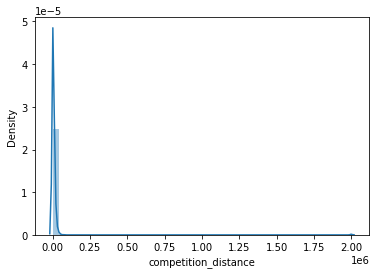

In [38]:
sns.distplot(df1['competition_distance'])

#### 1.7.2 Categorical Attributes - Descriptive Statistical 

In [39]:
#visualizar quantas variaçoes de cada elemento categorico existem
cat_atributes.apply(lambda x: x.unique().shape[0])


date              942
state_holiday       4
store_type          4
assortment          3
promo_interval      4
month_map          12
dtype: int64

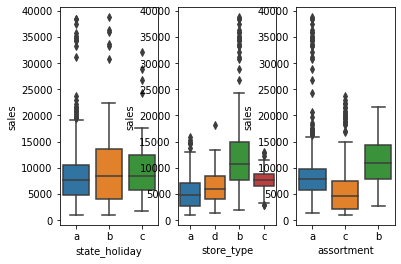

In [40]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1)
plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1)

## 2.0 Feature Engineering


In [41]:
df2 = df1.copy()

### 2.1 Mapa mental de Hipoteses

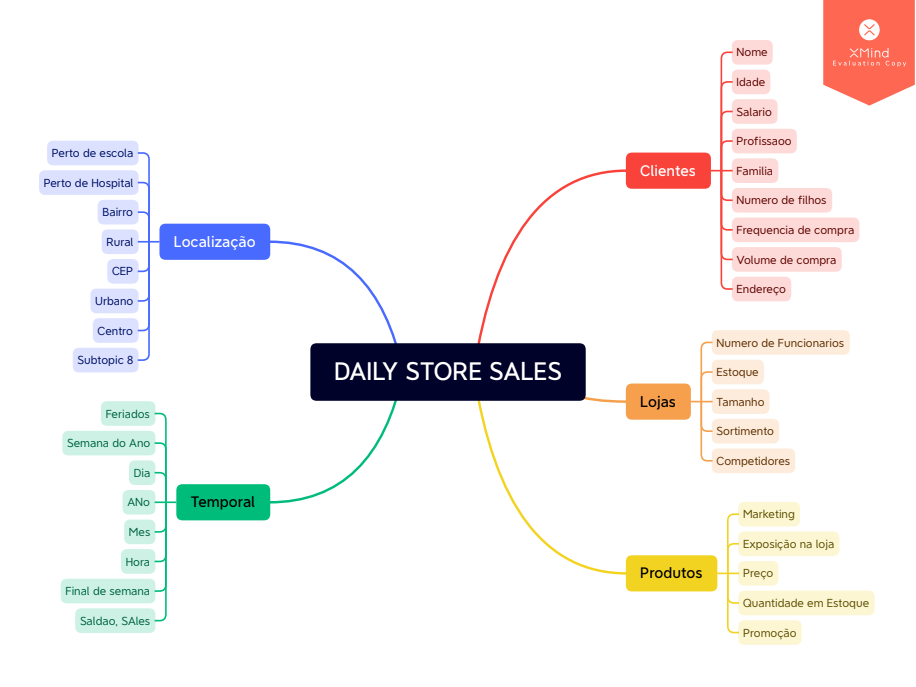

In [42]:
Image('/content/drive/MyDrive/Colab Notebooks/Data Science Em Produção/Projeto Rossman Store/img/Mapa Mental de Hipoteses - Rossman Store.png')

### 2.2 Criação de Hipoteses

#### 2.2.1 Hipoteses da Loja

1. Lojas com maior quadro de funcionarios vendes mais  
2. Lojas com maior estoque vendem mais
3. Lojas com maior porte deveriam vender mais
4. Lojas com menor porte deveriam vender menos
5. Lojas com Maior Sortimento deverias vender mais

#### 2.2.2 Hipoteses do Produto

1. Lojas que investes em marketing deveriam vender mais
2. Lojas que investes expoe mais produtos nas vitrines deveriam vender mais
3. Lojas que tem menores preços deveriam vender mais
4. Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais

#### 2.2.3 Hipoteses do Tempo

1. Lojas que tem mais feriados deveriam vender menos
2. Lojas que abrem nos primeiro 6 meses deveriam vender mais
3. Lojas que abrem nos finais de semana deveriam vender mais
4. Lojas Deveriam vender mais no segundo semestre do ano

### 2.3 Lista de Hipoteses

1. Lojas com Maior Sortimento deverias vender mais
2. Lojas com competidores mais proximos deveriam vender menos
3. Lojas com competidores à mais tempo deveriam vender mais


1. Lojas com promoções ativas a mais tempo deveriam vender mais
2. Lojas com mais dias de promoção deveriam vender mais
3. Lojas com mais promoçoes consecutivas deveram vender mais.

1. Lojas Abertas durante o feriado de natal deveriam vender mais
1. Lojas deveriam vender mais ao longo do anos
4. Lojas Deveriam vender mais no segundo semestre do ano
1. Lojas deveriam vender mais depois do 10 dia util do mes
1. Lojas deveriam vender menos aos finais de semana
1. Lojas que tem mais feriados deveriam vender menos
1. lojas deveriam vender menos durante os feriados escolares
2. Lojas que abrem nos primeiro 6 meses deveriam vender mais
3. Lojas que abrem nos finais de semana deveriam vender mais.


### 2.4 Derivar Features (Feature Engineering)

In [47]:
# Variaveis a Derivar:

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# day
df2['day'] = df2['date'].dt.day


# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition sice
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1) #quando o tiver mais de uma colunas envolvida, o Axis precisa ser igual a 1, pra passar por todas as colunas
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /7 ).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == "a" else 'extra' if x == "b" else 'extended')

# state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')



In [48]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [45]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int64
month        